In [229]:
%cd /content

/content


# Download Dataset

In [230]:
!gdown --id 1jOPFeBz5GvCeFVWIsIrJ1Xn9ObVZg_ei

Downloading...
From: https://drive.google.com/uc?id=1jOPFeBz5GvCeFVWIsIrJ1Xn9ObVZg_ei
To: /content/data.zip
660MB [00:05, 119MB/s]


In [231]:
!unzip data.zip

Archive:  data.zip
replace MT-Dataset/images/makeup/012ce0437aec38b7b42918f3e4971c13.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [232]:
# import the necessary packages
import os
import numpy as np

import torch
from PIL import Image
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import OneHotEncoder

from imutils import paths
import random
import shutil
import pprint
import time

from IPython import display

In [233]:
# resnet_model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)

# Change this with the re-trained ResNet-50 model
resnet_model = torch.load("/content/drive/MyDrive/fine_tune_makeup")
resnet_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Predict

In [235]:
feature_extractor = torch.nn.Sequential(*list(resnet_model.children())[:-1])
all_predictions = []

dataset = dset.ImageFolder(root="/content/MT-Dataset/images",
                           transform=transforms.Compose([
                              transforms.Resize(256),
                              transforms.CenterCrop(224),
                              transforms.ToTensor(),
                              transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                            ]))

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                         shuffle=True, num_workers=8)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

for i, input_batch in enumerate(dataloader, 0):
  if (i % 100 == 0):
    print(i)

  if torch.cuda.is_available():
      input_batch = input_batch[0].to('cuda')
      feature_extractor.to('cuda')

  with torch.no_grad():
      output = feature_extractor(input_batch)

  all_predictions.append(output.cpu().numpy())


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700


In [7]:
all_predictions = np.array(all_predictions)
all_predictions.shape

(2719, 1, 2048, 1, 1)

In [8]:
all_predictions = np.array(all_predictions)
pca_input = all_predictions.reshape(-1, 2048)
pca = PCA(n_components=512)
pca.fit(pca_input)
points = pca.transform(pca_input)
print(points.shape)

(2719, 512)


In [ ]:
if (points.shape[1] == 2):
  fig = plt.figure(figsize=(15,15))
  ax = fig.add_subplot(111)
  ax.scatter(points[:,0], points[:,1])
  plt.show()

if (points.shape[1] == 3):
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(points[:,0], points[:,1], points[:,2])
  plt.show()

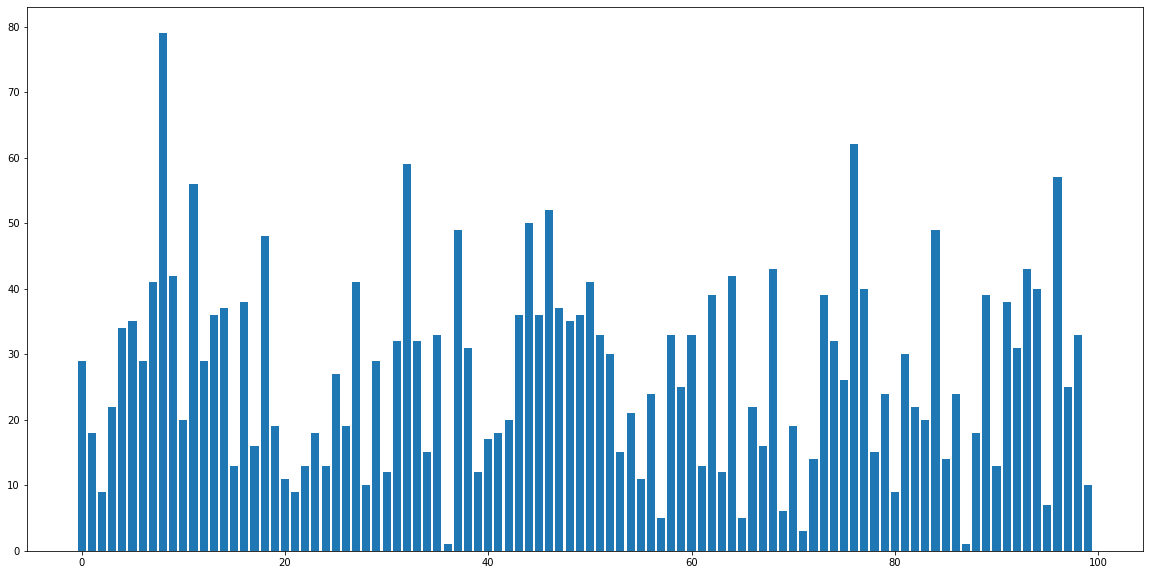

In [9]:
N_CLUSTER = 100

kmeans = KMeans(n_clusters=N_CLUSTER, random_state=0).fit(points)
label_dict = {}

for label in kmeans.labels_:
  if label not in label_dict:
    label_dict[label] = 1
  else:
    label_dict[label] += 1

plt.figure(figsize=(20,10))
plt.bar(*zip(*label_dict.items()))
plt.show()

In [10]:
labeled_images_dict = {}

#Label all makeup images
with open("/content/MT-Dataset/train_SYMIX.txt", "r") as f:
  lines = f.read().splitlines();
  for i, point in enumerate(points, 0):
    if (i >= len(lines)):
      break;
    label = kmeans.predict([points[i]])[0]
    labeled_images_dict["MT-Dataset/" + lines[i]] = label

#Label all non-makeup images
with open("/content/MT-Dataset/train_MAKEMIX.txt", "r") as f:
  lines = f.read().splitlines();
  for i, point in enumerate(points, 0):
    if (i >= len(lines)):
      break;
    labeled_images_dict["MT-Dataset/" + lines[i]] = N_CLUSTER

print("[INFO] Saved labels")

[INFO] Saved labels


In [ ]:
print(labeled_images_dict)

{'MT-Dataset/images/makeup/012ce0437aec38b7b42918f3e4971c13.png': 7, 'MT-Dataset/images/makeup/03480298a56454e8fab7df9efbff8040.png': 83, 'MT-Dataset/images/makeup/039.png': 37, 'MT-Dataset/images/makeup/04e2c48ab002327fc412786a51a36620.png': 9, 'MT-Dataset/images/makeup/0512fa1eb74daff32c1e81cbf736306f.png': 32, 'MT-Dataset/images/makeup/0556ab6f8b7c37609ab3ffd46678c125.png': 99, 'MT-Dataset/images/makeup/08d07734712422248a6af552f03453ea.png': 59, 'MT-Dataset/images/makeup/09001ec3246fb41a4c4aebf0069ed883.png': 13, 'MT-Dataset/images/makeup/0d384dbbcc121ca5049c423f81c26e6a.png': 32, 'MT-Dataset/images/makeup/0edb4c3c0ad23949c47f314dafe302d2.png': 13, 'MT-Dataset/images/makeup/0efbf1559e3deb7ee5f9003ea14b8425.png': 67, 'MT-Dataset/images/makeup/0f86560090f166c56a61f57e39322f35.png': 50, 'MT-Dataset/images/makeup/0fa4a0c941ca203c50d8188d7a6ae518.png': 18, 'MT-Dataset/images/makeup/11cd36947eaf3dc39ad7bb30939196af.png': 56, 'MT-Dataset/images/makeup/15d06c640213f4d70d42bf6a8ae28d05.png':

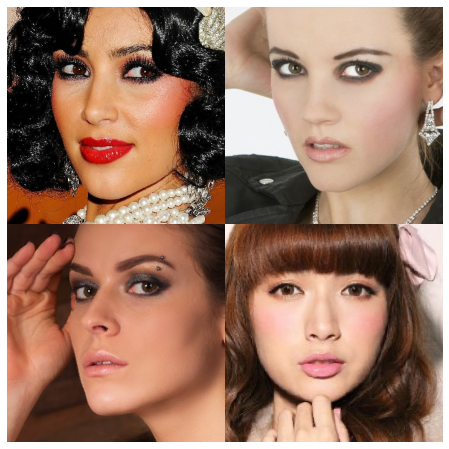

In [228]:
from mpl_toolkits.axes_grid1 import ImageGrid
# function to return key for any value
def get_key(val, d):
    keys = []
    for key, value in d.items():
         if val == value:
            keys.append(key)
    return keys

def sample_cluster(label, plt):
  imgs = get_key(label, labeled_images_dict)
  imgs = [plt.imread(x) for x in imgs]

  fig = plt.figure(figsize=(8, 8))
  grid = ImageGrid(fig, 111,  # similar to subplot(111)
                  nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                  axes_pad=0,  # pad between axes in inch.
                  )


  for ax, im in zip(grid, imgs):
      # Iterating over the grid returns the Axes.
      ax.axis("off")
      ax.imshow(im)

sample_cluster(12, plt)

# DCGAN

In [12]:
from __future__ import print_function

import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [217]:
# Root directory for dataset
dataroot = "MT-Dataset/images"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 512

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 10

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1


n_cluster = N_CLUSTER + 1

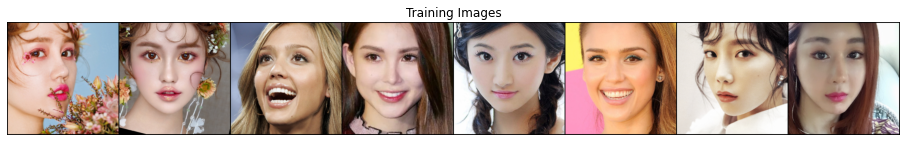

In [218]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(16,16))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:8], padding=2, normalize=True).cpu(),(1,2,0)))

In [219]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [220]:
# Generator Code
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.n_cluster = n_cluster

        self.block_1 = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz + self.n_cluster, ngf * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
        )

        self.block_2 = nn.Sequential(
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8 + self.n_cluster, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
        )

        self.block_3 = nn.Sequential(
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4 + self.n_cluster, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
        )

        self.block_4 = nn.Sequential(
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2 + self.n_cluster, ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
        )

        self.block_5 = nn.Sequential(
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf + self.n_cluster, nc, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
        # state size. (nc) x 64 x 64

    def forward(self, input, label):
      one_hot_vector = torch.nn.functional.one_hot(label, self.n_cluster).reshape((input.shape[0], self.n_cluster, 1, 1))
      x = torch.cat((input, one_hot_vector), 1)

      x = self.block_1(x)

      one_hot_feature = one_hot_vector * torch.ones([x.shape[0], self.n_cluster, x.shape[2], x.shape[3]]).cuda()
      x = torch.cat((x, one_hot_feature), 1)
      x = self.block_2(x)

      one_hot_feature = one_hot_vector * torch.ones([x.shape[0], self.n_cluster, x.shape[2], x.shape[3]]).cuda()
      x = torch.cat((x, one_hot_feature), 1)
      x = self.block_3(x)

      one_hot_feature = one_hot_vector * torch.ones([x.shape[0], self.n_cluster, x.shape[2], x.shape[3]]).cuda()
      x = torch.cat((x, one_hot_feature), 1)
      x = self.block_4(x)

      one_hot_feature = one_hot_vector * torch.ones([x.shape[0], self.n_cluster, x.shape[2], x.shape[3]]).cuda()
      x = torch.cat((x, one_hot_feature), 1)
      x = self.block_5(x)

      return x

In [221]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (block_1): Sequential(
    (0): ConvTranspose2d(613, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (block_2): Sequential(
    (0): ConvTranspose2d(613, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (block_3): Sequential(
    (0): ConvTranspose2d(357, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (block_4): Sequential(
    (0): ConvTranspose2d(229, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (block_5): Sequential(
  

In [222]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.n_cluster = n_cluster

        self.block_1 = nn.Sequential( 
          # input is (nc) x 64 x 64
          nn.Conv2d(nc + self.n_cluster, ndf, 4, 2, 1, bias=False),
          nn.LeakyReLU(0.2, inplace=True)
        )

        self.block_2 = nn.Sequential(
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf + self.n_cluster, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
        )

        self.block_3 = nn.Sequential(
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2 + self.n_cluster, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.block_4 = nn.Sequential(
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4 + self.n_cluster, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.block_5 = nn.Sequential( 
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8 + self.n_cluster, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
          )

    def forward(self, input, label):
      # Input shape: torch.Size([128, 3, 64, 64])
      # One hot vector shape: torch.Size([128, 129, 1, 1])
      # torch.ones shape: torch.Size([128, 129, 64, 64])
      one_hot_vector = torch.nn.functional.one_hot(label.to(torch.int64), self.n_cluster).reshape((input.shape[0], self.n_cluster, 1, 1))
      one_hot_feature = one_hot_vector * torch.ones([input.shape[0], self.n_cluster, input.shape[2], input.shape[3]]).cuda()

      x = torch.cat((input, one_hot_feature), 1)
      x = self.block_1(x)

      one_hot_feature = one_hot_vector * torch.ones([x.shape[0], self.n_cluster, x.shape[2], x.shape[3]]).cuda()
      x = torch.cat((x, one_hot_feature), 1)
      x = self.block_2(x)

      one_hot_feature = one_hot_vector * torch.ones([x.shape[0], self.n_cluster, x.shape[2], x.shape[3]]).cuda()
      x = torch.cat((x, one_hot_feature), 1)
      x = self.block_3(x)

      one_hot_feature = one_hot_vector * torch.ones([x.shape[0], self.n_cluster, x.shape[2], x.shape[3]]).cuda()
      x = torch.cat((x, one_hot_feature), 1)
      x = self.block_4(x)

      one_hot_feature = one_hot_vector * torch.ones([x.shape[0], self.n_cluster, x.shape[2], x.shape[3]]).cuda()
      x = torch.cat((x, one_hot_feature), 1)
      x = self.block_5(x)
      
      return x

In [223]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (block_1): Sequential(
    (0): Conv2d(104, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (block_2): Sequential(
    (0): Conv2d(165, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block_3): Sequential(
    (0): Conv2d(229, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (block_4): Sequential(
    (0): Conv2d(357, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (block_5): Sequential(
    (0): Conv2d(613, 1, kernel_size=(4, 4), stride=(1, 1), b

In [224]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
fixed_labels = torch.randint(0, n_cluster, size=(64, ), device=device)
print(fixed_labels)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

tensor([ 73,  77, 100,  25,  21,  82,  42,  68,   8,  97,  28,  68,   1,  36,
         77,  45,  58,  17,  50,  88,  63,  92,  20,  72,  91,  74,  60,  33,
         31,  11,  86,  47,  80,  16,  77,  58,  96,  81,  56,  68,  41,  96,
         40,  27,  58,  38,  69,  53,  52,  88,  22,  53,   0,  19,  66,  93,
         44,  80,  39,  85,  77,  30,  84,   8], device='cuda:0')


In [225]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        cur_samples = dataloader.dataset.samples[i * batch_size : i * batch_size + batch_size]
        file_names = list(zip(*cur_samples))[0]
        cluster_labels = torch.tensor([labeled_images_dict[x] for x in file_names], device=device)
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu, cluster_labels).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        rand_labels = torch.randint(0, n_cluster, size=(data[0].shape[0], ), device=device)
        # Generate fake image batch with G
        fake = netG(noise, rand_labels)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach(), rand_labels).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake, rand_labels).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise, fixed_labels).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...


ValueError: ignored

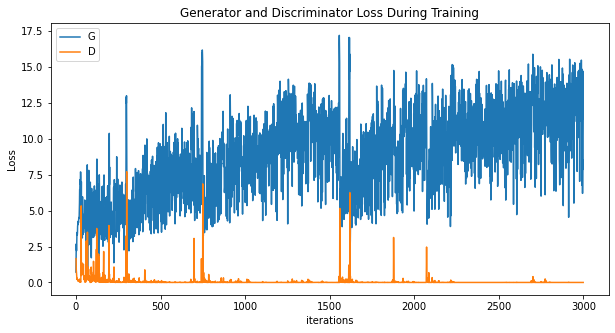

In [49]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

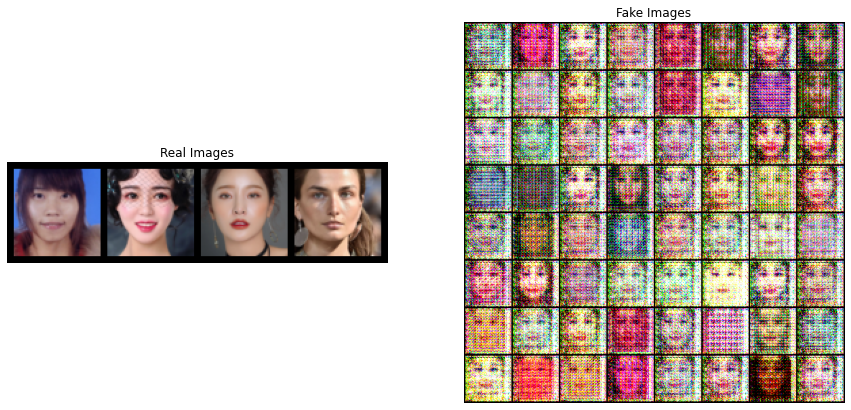

In [50]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:4], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

# Generate Makeup By Style

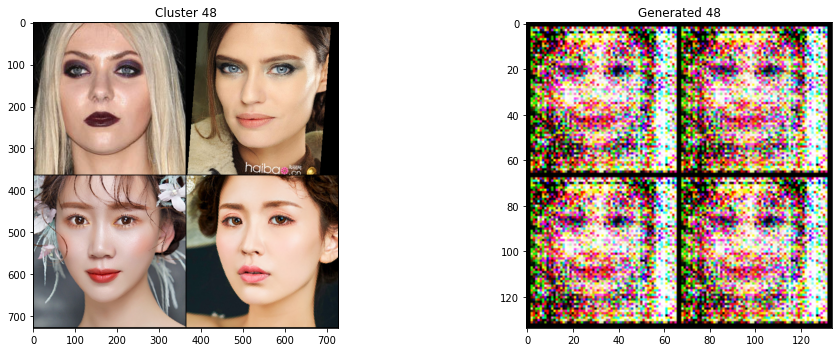

[[[4.0748888e-01 7.8882170e-01 5.0846435e-02]
  [3.1214046e-01 1.9856844e-02 1.9094709e-02]
  [9.8424166e-01 8.1924349e-01 4.6673247e-01]
  ...
  [9.7496158e-01 9.8289126e-01 8.4839720e-01]
  [9.0853804e-01 2.4647753e-01 9.7511882e-01]
  [5.0531633e-02 9.7415835e-01 9.6836478e-01]]

 [[2.8485179e-01 9.6403879e-01 2.7986223e-01]
  [7.2789206e-03 9.9939102e-01 9.8855036e-01]
  [1.3336542e-04 9.9921352e-01 5.6813025e-01]
  ...
  [9.9924999e-01 9.9795717e-01 9.9928874e-01]
  [1.1430087e-03 9.9361396e-01 2.4582164e-01]
  [9.9873823e-01 8.9928561e-01 9.9258822e-01]]

 [[6.0977739e-01 9.6643227e-01 7.6607778e-03]
  [4.1783223e-01 9.8201656e-04 9.6240657e-04]
  [2.8704142e-02 9.7553451e-03 3.6111480e-04]
  ...
  [6.3989437e-01 9.9905467e-01 7.2337341e-01]
  [4.5001516e-04 4.6712169e-04 9.9802536e-01]
  [1.1957886e-02 9.8366123e-01 9.2838800e-01]]

 ...

 [[9.9770528e-01 8.8755226e-01 5.3372359e-01]
  [5.3169141e-03 9.9752557e-01 4.9113045e-03]
  [9.8495126e-01 1.0981562e-03 2.9054290e-04]
  ..

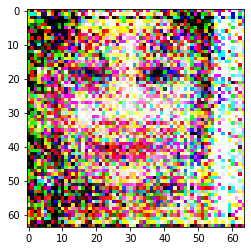

In [152]:
noise = torch.randn(4, nz, 1, 1, device=device)
makeup_label = torch.randint(0, n_cluster,size=(1, ), device=device)
label_tensor = torch.tensor([makeup_label.cpu().numpy()[0] for i in range(4)], device=device)

new_makeup = netG(noise, label_tensor).detach().cpu()

#Example cluster images by label
imgs = get_key(makeup_label.cpu().numpy()[0], labeled_images_dict)
imgs = [np.transpose(plt.imread(x), (2, 0, 1)) for x in imgs]
imgs = torch.tensor(imgs, device=device)

cluster_imgs = np.transpose(vutils.make_grid(imgs.to(device)[:4], padding=2, nrow=2).cpu(), (1,2,0))

plt.figure(figsize=([15, 5]))
plt.subplot(121), plt.imshow(cluster_imgs), plt.title("Cluster " + str(makeup_label.cpu().numpy()[0] ))
plt.subplot(122),  plt.imshow(np.transpose(vutils.make_grid(new_makeup.to(device)[:4], padding=2, normalize=True, nrow=2).cpu(),(1,2,0))), plt.title("Generated " + str(makeup_label.cpu().numpy()[0]))
plt.tight_layout()
plt.show()

save_image = np.array(np.transpose(new_makeup.to(device)[-1].detach().cpu(), (1, 2, 0)))
save_image = (save_image - save_image.min()) / (save_image.max() - save_image.min())

plt.imsave("/content/generated_images/generated_cluster_image.png", save_image)

# Apply Makeup

In [52]:
!git clone https://github.com/wtjiang98/PSGAN.git

Cloning into 'PSGAN'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 129 (delta 31), reused 75 (delta 12), pack-reused 25
Receiving objects: 100% (129/129), 169.31 MiB | 38.69 MiB/s, done.
Resolving deltas: 100% (32/32), done.
Checking out files: 100% (53/53), done.


In [61]:
!pip install torchgpipe
!pip install fvcore
!pip install fire

     |████████████████████████████████| 81kB 6.4MB/s 
  Created wheel for fire: filename=fire-0.3.1-py2.py3-none-any.whl size=111006 sha256=d7e34e9ca1dfdce8f8a673ad2146aa496667ea97cb93ba17aea67de4816ca14c
  Stored in directory: /root/.cache/pip/wheels/c1/61/df/768b03527bf006b546dce284eb4249b185669e65afc5fbb2ac
Successfully built fire


In [ ]:
!cd PSGAN && python3 demo.py --reference_dir content/generated_images --device cuda